In [1]:
# load needed modules
import numba 
import numpy as np

import time

import numpy as np
from numba import cuda
from math import ceil 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#print out gpu information

gpu = numba.cuda.get_current_device()
print("name = %s" % gpu.name)
print("maxThreadsPerBlock = %s" % str(gpu.MAX_THREADS_PER_BLOCK))
print("maxBlockDimX = %s" % str(gpu.MAX_BLOCK_DIM_X))
print("maxBlockDimY = %s" % str(gpu.MAX_BLOCK_DIM_Y))
print("maxBlockDimZ = %s" % str(gpu.MAX_BLOCK_DIM_Z))
print("maxGridDimX = %s" % str(gpu.MAX_GRID_DIM_X))
print("maxGridDimY = %s" % str(gpu.MAX_GRID_DIM_Y))
print("maxGridDimZ = %s" % str(gpu.MAX_GRID_DIM_Z))
print("maxSharedMemoryPerBlock = %s" % str(gpu.MAX_SHARED_MEMORY_PER_BLOCK))
print("asyncEngineCount = %s" % str(gpu.ASYNC_ENGINE_COUNT))
print("canMapHostMemory = %s" % str(gpu.CAN_MAP_HOST_MEMORY))
print("multiProcessorCount = %s" % str(gpu.MULTIPROCESSOR_COUNT))
print("warpSize = %s" % str(gpu.WARP_SIZE))
print("unifiedAddressing = %s" % str(gpu.UNIFIED_ADDRESSING))
print("pciBusID = %s" % str(gpu.PCI_BUS_ID))
print("pciDeviceID = %s" % str(gpu.PCI_DEVICE_ID))

name = b'Tesla K80'
maxThreadsPerBlock = 1024
maxBlockDimX = 1024
maxBlockDimY = 1024
maxBlockDimZ = 64
maxGridDimX = 2147483647
maxGridDimY = 65535
maxGridDimZ = 65535
maxSharedMemoryPerBlock = 49152
asyncEngineCount = 2
canMapHostMemory = 1
multiProcessorCount = 13
warpSize = 32
unifiedAddressing = 1
pciBusID = 5
pciDeviceID = 0


In [2]:
#generate dummy data for test

Nz, Ny, Nx = 128, 512, 128

real_data = (np.ones((Nz, Ny, Nx)) * np.sin(np.linspace(0, 20, Ny)[np.newaxis, :, np.newaxis])*0.5 
             + np.random.normal(scale=1.0, size=(Nz, Ny, Nx)) )

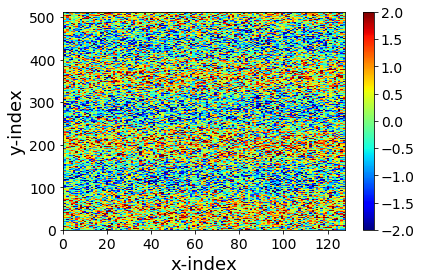

In [3]:
#visulize date: before filtering:

plt.pcolormesh(real_data[Nz//2,:, :], vmin=-2, vmax=2, cmap=plt.cm.jet)

cb = plt.colorbar()
for i in cb.ax.get_yticklabels():
    i.set_fontsize(14)
    
plt.xlabel("x-index", fontsize=18)
plt.xticks( fontsize=14)
plt.ylabel("y-index", fontsize=18)
plt.yticks( fontsize=14)

plt.tight_layout()

plt.show()

In [4]:
# define the output result: same size of input data
output_data = real_data.copy()

#define the stencil size (3D)
stencil = (8, 6, 8)

In [5]:


# =================================== reduce =================================== #

'''
 @param:
     - input_data:  np.array, 3D data to filter
     - output_data: np.array, 3D data after filtering,same size of input (because cuda kernel function can't return value)
     - fkt:         function, numba_median, numba_avgerage, ... (what else?)
     - stencil:     tuple of size 3, the dimension of 3D stencil 
     
 @function: 
     stencil filter on GPU, reference: https://en.wikipedia.org/wiki/Stencil_code
'''



@cuda.jit
def gpu_smooth_kernel_naive(input_data, output_data, stencil_z, stencil_y, stencil_x, Nz, Ny, Nx):
    # ==== stencil size ==== #
    #dx = stencil_[0] dosen't work, compile issue
    #dy = stencil_[1]
    #dz = stencil_[2]
    dx = stencil_x
    dy = stencil_y
    dz = stencil_z
    # ====================== #
    
    row_global = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x;
    col_global = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y;
    depth_global = cuda.threadIdx.z + cuda.blockIdx.z * cuda.blockDim.z;
    
    # grid stride:
    while(depth_global < Nz):
        z_min = max(depth_global - dz, 0)
        z_max = min(depth_global + dz + 1, Nz)
        while(col_global < Ny):
            y_min = max(col_global - dy, 0)
            y_max = min(col_global + dy + 1, Ny)
            while(row_global < Nx):
                
                x_min = max(row_global - dx, 0)
                x_max = min(row_global + dx + 1, Nx)
                
                #print(input_data[z_min:z_max, y_min:y_max, x_min:x_max]) 
                # there is an error here, numba.cuda because of index
                '''
                From Numba docs: 
                "Arrays support normal iteration. Full basic indexing and slicing is supported.
                A subset of advanced indexing is also supported: only one advanced index is allowed, 
                and it has to be a one-dimensional array (it can be combined with an arbitrary number of basic indices as well)."
                '''
                # https://stackoverflow.com/questions/33437183/arrays-in-cuda-kernels-using-python-with-numba-pro
                # https://groups.google.com/a/continuum.io/forum/#!topic/numba-users/l1dQR-Ol8NA
                
                sum = 0.0
                
                # reduce in each thread, simplest way
                for i in range(z_min,z_max):
                    for j in range(y_min,y_max):
                        for k in range(x_min,x_max):
                            sum += input_data[i,j,k]
                            
                output_data[depth_global, col_global, row_global] = sum / ((z_max - z_min) * (y_max - y_min) * (x_max - x_min))
                
                row_global += cuda.blockDim.x * cuda.gridDim.x
            col_global += cuda.blockDim.y * cuda.gridDim.y
        depth_global += cuda.blockDim.z * cuda.gridDim.z

        
def lauch_kernel(input_data, output_data, stencil_):
    # TODO: set blocksize, gridsize and lauch kernel
    # define threads and blocks
    threads = 256
    blocks = 2048/threads * 13 
    print("==================")
    print("threads: " + str(threads))
    print("blocks: " + str(blocks))
    print("==================")
    
    Nz, Ny, Nx = np.shape(input_data) # why here z, y, x ?
    stencil_z, stencil_y, stencil_x = stencil_[0], stencil_[1], stencil_[2]
    start = time.time()
    # call CUDA kernel
    gpu_smooth_kernel_naive[(threads, 1, 1), (int(blocks), 1, 1)](input_data, output_data,stencil_z, stencil_y, stencil_x, Nz, Ny, Nx)
   
    #gpu_smooth_kernel_naive[(1,1,1), (1,1,1)](input_data, output_data,stencil_z, stencil_y, stencil_x, Nz, Ny, Nx)
    #Elapsed (gpu naive with compilation) = 0.6353635787963867
    #Elapsed (gpu naive without compilation) = 0.09616756439208984
    
    end = time.time()
    print("Elapsed (gpu naive with compilation) = %s" % (end - start))

    start = time.time()
    gpu_smooth_kernel_naive[(threads, 1, 1), (int(blocks), 1, 1)](input_data, output_data,stencil_z, stencil_y, stencil_x, Nz, Ny, Nx)
    end = time.time()
    print("Elapsed (gpu naive without compilation) = %s" % (end - start))


In [6]:
stencil_t = np.array([8, 6, 8])
lauch_kernel(real_data, output_data, stencil_t)



threads: 256
blocks: 104.0


CudaSupportError: Error at driver init: 
[803] Call to cuInit results in UNKNOWN_CUDA_ERROR: